In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import random

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

from tqdm import tqdm

import json

%matplotlib inline

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path_hr_img = './data/div2k/DIV2K_train_HR'
path_lr_x2_img = './data/div2k/DIV2K_train_LR_unknown/X2'
patch_size = (128,128)
images_lr = []
images_hr = []
images_lr_patches = []
images_hr_patches = []


for filename in tqdm(os.listdir(path_lr_x2_img)):
    img = read_image(os.path.join(path_lr_x2_img, filename))
    transform = torchvision.transforms.Compose([
        v2.ToPureTensor(),
        v2.ToDtype(torch.float)
    ])
    img = transform(img) #/255.
    images_lr.append(img)
    patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0], patch_size[1]).unfold(2, patch_size[0], patch_size[1])
    size = patches[0].shape
    for i in range(size[0]):
        for j in range(size[1]):
            images_lr_patches.append(patches[0][i][j])

for filename in tqdm(os.listdir(path_hr_img)):
    img = read_image(os.path.join(path_hr_img, filename))
    transform = torchvision.transforms.Compose([
        v2.ToPureTensor(),
        v2.ToDtype(torch.float)
    ])
    img = transform(img) #/255.
    images_hr.append(img)
    patches = img.data.unfold(0, 3, 3).unfold(1, patch_size[0]*2, patch_size[1]*2).unfold(2, patch_size[0]*2, patch_size[1]*2)
    size = patches[0].shape
    for i in range(size[0]):
        for j in range(size[1]):
            images_hr_patches.append(patches[0][i][j])


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [04:39<00:00,  2.86it/s]


In [5]:
images_hr_fathers = []
images_lr_sons = []
scales = [2, 3, 4, 5, 6, 7, 8, 9]
scale_son=2

for image in tqdm(images_lr):
    for scale in scales:    
        resizes = {
            'bilinear': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                     antialias=True),
            'nearest': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                     antialias=True),
            'nearest_exact': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                     antialias=True),
            'bicubic': torchvision.transforms.Resize((int(image.shape[1]/scale), int(image.shape[2]/scale)),
                                                     interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                     antialias=True),  
        }
        resize_as = random.choice(list(resizes.values()))
        image_downscale = resize_as(image)
        if image_downscale.shape[1] % 2 != 0 or image_downscale.shape[2] %2 != 0:
            new_h = image_downscale.shape[1] - 1 if image_downscale.shape[1] % 2 != 0 else image_downscale.shape[1]
            new_w = image_downscale.shape[2] - 1 if image_downscale.shape[2] % 2 != 0 else image_downscale.shape[2]
            crop = torchvision.transforms.CenterCrop((new_h, new_w))
            image_downscale = crop(image_downscale)
            
        augmenters = {
            #'Rotate90': torchvision.transforms.RandomRotation(degrees=(90,90), expand=True),
            #'Rotate180': torchvision.transforms.RandomRotation(degrees=(180,180), expand=True),
            #'Rotate270': torchvision.transforms.RandomRotation(degrees=(270,270), expand=True),
            'HFlip': torchvision.transforms.RandomHorizontalFlip(p=1),
            'VFlip': torchvision.transforms.RandomVerticalFlip(p=1),
        }
        for (augmenter_name, augmenter) in augmenters.items():
            resizes_son = {
                'bilinear': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                           int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
                                                         antialias=True),
                'nearest': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                          int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.NEAREST,
                                                         antialias=True),
                'nearest_exact': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                                int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT,
                                                         antialias=True),
                'bicubic': torchvision.transforms.Resize((int(image_downscale.shape[1]/scale_son),
                                                          int(image_downscale.shape[2]/scale_son)),
                                                         interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
                                                         antialias=True),  
            }
            resize_as = random.choice(list(resizes_son.values()))
            image_downscale_son = resize_as(image_downscale)
            img_aug_father = augmenter(image_downscale)
            img_aug_son = augmenter(image_downscale_son)
            images_hr_fathers.append(img_aug_father)
            images_lr_sons.append(img_aug_son)


100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [02:32<00:00,  5.26it/s]


In [88]:
print(images_hr[0].shape, images_lr[0].shape)
for i in range(len(images_hr_fathers)):
    print (images_hr_fathers[i].shape, images_lr_sons[i].shape)

torch.Size([3, 1404, 2040]) torch.Size([3, 702, 1020])
torch.Size([3, 350, 510]) torch.Size([3, 175, 255])
torch.Size([3, 350, 510]) torch.Size([3, 175, 255])
torch.Size([3, 234, 340]) torch.Size([3, 117, 170])
torch.Size([3, 234, 340]) torch.Size([3, 117, 170])
torch.Size([3, 174, 254]) torch.Size([3, 87, 127])
torch.Size([3, 174, 254]) torch.Size([3, 87, 127])
torch.Size([3, 140, 204]) torch.Size([3, 70, 102])
torch.Size([3, 140, 204]) torch.Size([3, 70, 102])
torch.Size([3, 116, 170]) torch.Size([3, 58, 85])
torch.Size([3, 116, 170]) torch.Size([3, 58, 85])
torch.Size([3, 100, 144]) torch.Size([3, 50, 72])
torch.Size([3, 100, 144]) torch.Size([3, 50, 72])
torch.Size([3, 86, 126]) torch.Size([3, 43, 63])
torch.Size([3, 86, 126]) torch.Size([3, 43, 63])
torch.Size([3, 78, 112]) torch.Size([3, 39, 56])
torch.Size([3, 78, 112]) torch.Size([3, 39, 56])


12800
torch.Size([3, 140, 204]) torch.Size([3, 70, 102])


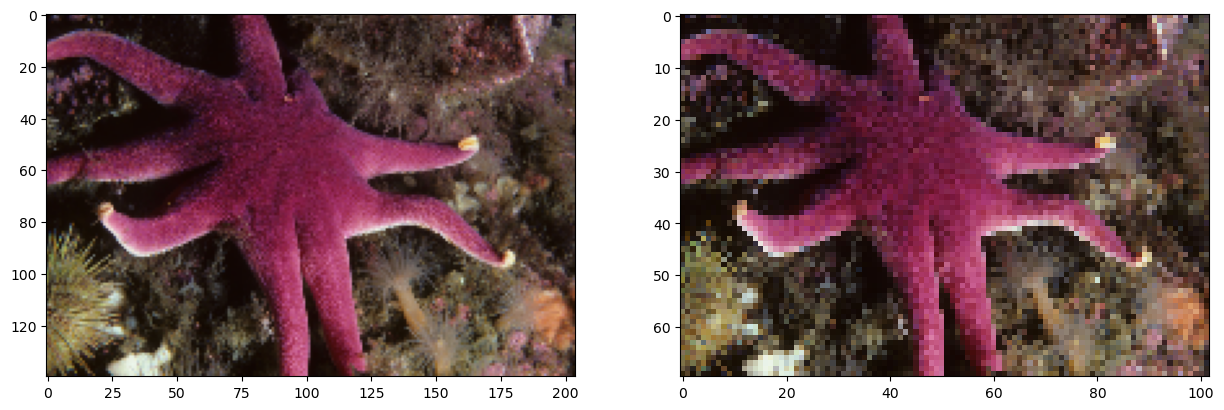

In [6]:
print(len(images_hr_fathers))
n=6
plt.subplots(1,2, figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(images_hr_fathers[n].permute(1,2,0).type(torch.LongTensor))
plt.subplot(1,2,2)
plt.imshow(images_lr_sons[n].permute(1,2,0).type(torch.LongTensor))
print(images_hr_fathers[n].shape, images_lr_sons[n].shape)

In [7]:
class images_dataset(Dataset):
    def __init__(self, data_source, data_target):
        self.data_source = data_source
        self.data_target = data_target
        
    def __len__(self):
        return len(self.data_source)
    
    def __getitem__(self, index):
        data_source = self.data_source[index]
        data_target = self.data_target[index]
        return data_source, data_target

In [8]:
def collate_fn(batch):
    data_source = torch.LongTensor([item[0] for item in batch])
    data_target = torch.LongTensor([item[1] for item in batch])
    return data_source, data_target

In [28]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.bn = nn.BatchNorm2d(kwargs['out_channels'])
        self.activation = nn.GELU()
        
    def forward(self, x):
        x_input = x
        x = self.conv(x_input)
        x = self.bn(x)
        x = self.activation(x)
        return x + x_input
        

class lrdown2lr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, max_value=1.):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.max_value = max_value
        
        #self.upscale = nn.Upsample(scale_factor=2)
        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3*scale*scale, kernel_size=(1,1), stride=1, padding='same'),
            nn.PixelShuffle(upscale_factor=scale)
        )
        
        #self.conv = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.GELU(),
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.GELU()
        #)
        #self.conv_resc1 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same'),
        #    nn.GELU()
        #)
        
        
        
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, padding='same'),
            nn.GELU()
        )
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.GELU()
        )

    
    def forward(self, x):
        x = self.upscale(x)
        #x = self.conv(x) + self.conv_resc1(x)
        x = self.conv_in(x)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        x = torch.clamp(x, min=0., max=self.max_value)
       
        return x



In [20]:
class conv_block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x_input = x
        x = self.conv(x_input)
        x = self.activation(x)
        return x # + x_input
        

class zssr(nn.Module):
    def __init__(self, scale=2, n_blocks=8, channels=64, max_value=1.):
        super().__init__()
        
        self.n_blocks = n_blocks
        self.channels = channels
        self.max_value = max_value
        

        self.upscale = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3*scale*scale, kernel_size=(1,1), stride=1, padding='same'),
            nn.PixelShuffle(upscale_factor=scale)
        )
        
        self.conv_in = nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=(1,1), stride=1, padding='same')
        
       
        self.conv_inner_blocks = nn.ModuleList(conv_block(in_channels=channels,
                                     out_channels=channels,
                                     kernel_size=3,
                                     padding='same') for n in range(n_blocks))
        
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=3, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    
    def forward(self, x):
        x0 = self.upscale(x)
        x = self.conv_in(x0)
        for conv_inner in self.conv_inner_blocks:
            x = conv_inner(x)
        x = self.conv_out(x)
        x = torch.add(x, x0)
        x = torch.clamp(x, min=0., max=self.max_value)
       
        return x

In [11]:
class torch_trainer():
    
    def __init__(self, model, criterion, optimizer, epochs, dataloader, device='cuda', scheduler=None, metrics=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.dataloader = dataloader
        self.device = device
        self.history = loss_history()
        self.metrics = metrics
        
    
        
    def train(self):

        self.history.clear()
        loss = 0
        val_loss = 0

        for epoch in range(self.epochs):

            epoch_loss = []
            epoch_val_loss = []
            epoch_metrics = []
            items = len(self.dataloader['train'])

            self.model.train()
            item=1
            for batch in self.dataloader['train']:
                self.optimizer.zero_grad()
                data = batch[0].to(device)
                preds = self.model(data)
                del data
                target = batch[1].to(device)
                loss = self.criterion(preds, target)
                loss.backward()
                del target
                del preds
                epoch_loss.append(loss.numpy(force=True))
                self.optimizer.step()
                print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                item+=1

            items = len(self.dataloader['test'])
            self.model.eval()
            item=1
            with torch.no_grad():
                for batch in self.dataloader['test']:
                    data = batch[0].to(device)
                    preds = self.model(data)
                    del data
                    target = batch[1].to(device)
                    val_loss = self.criterion(preds, target)
                    if self.metrics:
                        metric = self.metrics(preds, target)
                        epoch_metrics.append(metric.numpy(force=True))
                    del target
                    del preds
                    epoch_val_loss.append(val_loss.numpy(force=True))
                    print (f'epoch {epoch+1}/{self.epochs}... {item}/{items}: train loss: {loss:.4f}, val_loss: {val_loss:.4f}', end='\r')
                    item+=1                  
                    
            loss = np.array(epoch_loss).mean()
            val_loss = np.array(epoch_val_loss).mean()
            metric = np.array(epoch_metrics).mean()

            if scheduler:
                scheduler.step(loss) 
                        
            
            self.history.loss.append(loss)
            self.history.val_loss.append(val_loss)
            lr = optimizer.param_groups[0]["lr"]
            
            if self.metrics:
                print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr}; metric={metric:.4f}', end='\n')
            else:
                print (f'epoch {epoch+1}/{self.epochs}; train loss: {loss:.4f}, val_loss: {val_loss:.4f}; lr={lr}', end='\n')

        return self.history

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print (device) 

cuda


In [25]:
ds_lr_downscaled = images_dataset(images_lr_sons[:10], images_hr_fathers[:10])
ds_lr_downscaled_train, ds_lr_downscaled_test = torch.utils.data.random_split(ds_lr_downscaled, [0.8, 0.2])

BATCH_SIZE = 1

dl_lrdown2lr_train = DataLoader(ds_lr_downscaled_train,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
dl_lrdown2lr_test = DataLoader(ds_lr_downscaled_test,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

dl_lrdown2lr = {'train': dl_lrdown2lr_train, 'test': dl_lrdown2lr_test}

In [15]:
def loss_tv(y_pred, y_true):
    loss = TVLoss()(y_pred)
    loss = 1000/loss + 0.01*nn.SmoothL1Loss()(y_pred, y_true)
    return loss

In [16]:
def fft_loss(y_pred, y_true):
    loss = torch.sum(torch.abs(torch.fft.rfft(y_pred, 1)))
    loss = 100/loss + 10*nn.SmoothL1Loss()(y_pred, y_true)
    return loss    

In [17]:
def loss_ssim_l2(y_pred, y_true):
    loss_ssim = 1. - ssim(y_pred, y_true, data_range=255)
    loss_l2 = nn.MSELoss()(y_pred, y_true)
    return loss_ssim + loss_l2

In [18]:
def metric_ssim(y_pred, y_true):
    return ssim(y_pred, y_true, data_range=255.)

In [29]:
torch.cuda.empty_cache()
model = lrdown2lr(n_blocks=8, channels=128, max_value=255).to(device)
print(model)
criterion = nn.L1Loss()
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)
trainer = torch_trainer(model=model,
                       criterion=criterion,
                       optimizer=optimizer,
                       metrics= metric_ssim,
                       epochs=40,
                       dataloader=dl_lrdown2lr)
history = trainer.train()

lrdown2lr(
  (upscale): Sequential(
    (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): PixelShuffle(upscale_factor=2)
  )
  (conv_in): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
  (conv_inner_blocks): ModuleList(
    (0-7): 8 x conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Sequential(
    (0): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
)
epoch 1/40; train loss: 43.7765, val_loss: 44.1176; lr=0.01; metric=0.4079
epoch 2/40; train loss: 23.1503, val_loss: 22.4608; lr=0.01; metric=0.5064
epoch 3/40; train loss: 17.9967, val_loss: 17.7784; lr=0.01; metric=0.5582
epoch 4/40; train loss: 14.7629, val_loss: 12.9389; lr=0.0

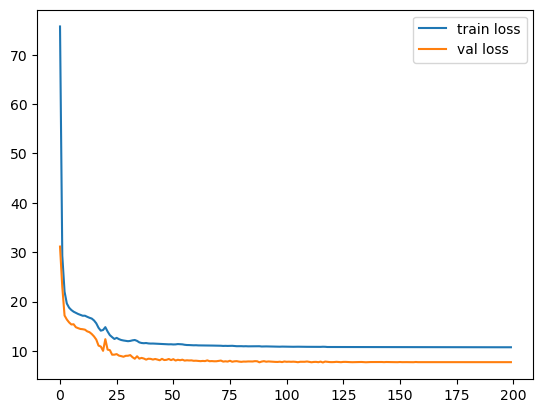

In [118]:
plot_history(history)

In [18]:
def plot_history(history):
    plt.plot(history.loss, label='train loss')
    plt.plot(history.val_loss, label='val loss')
    plt.legend()
    plt.show()

In [39]:
del model

AssertionError: Expected tensors with same size, got torch.Size([1, 3, 256, 256]) and torch.Size([1, 3, 512, 512])

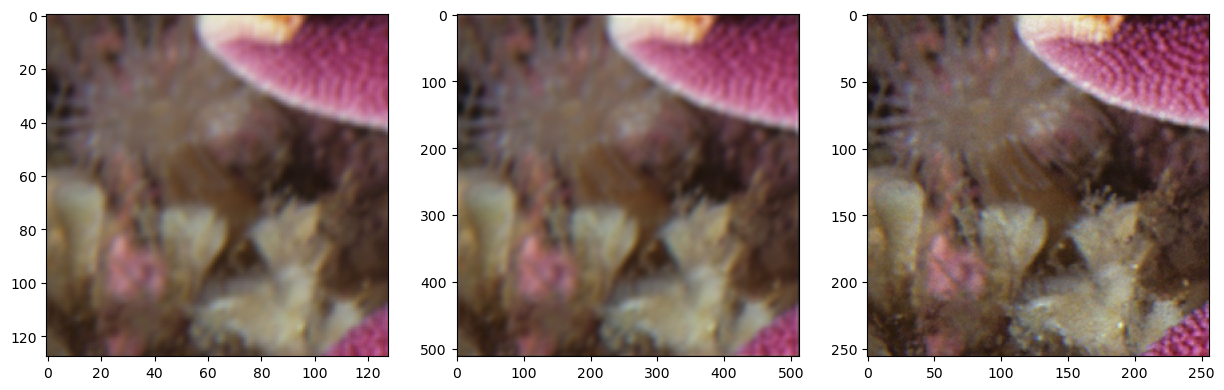

In [57]:
n = 15
ref = images_hr_patches[n]

#model = model.to('cpu')
test = images_lr_patches[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0], 'div2k_out.png')

plt.subplots(1,3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(images_lr_patches[n].permute(1,2,0).type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(images_hr_patches[n].permute(1,2,0).type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=255)
print(ssim_after)

tensor(0.9196)


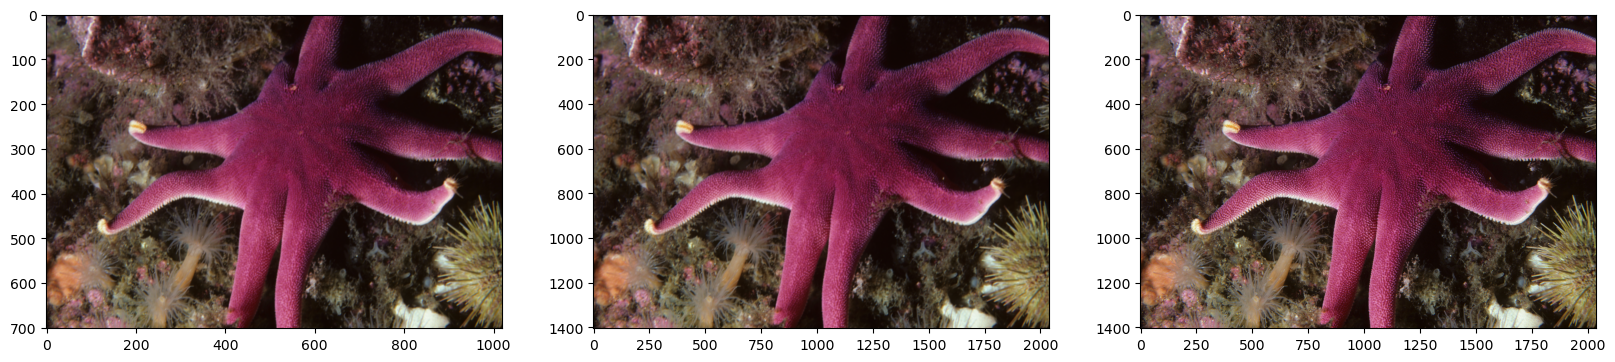

In [42]:
n = 0
ref = images_hr[n]

#model = model.to('cpu')
test = images_lr[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
img = preds[0].permute(1,2,0).to('cpu')
torchvision.utils.save_image(preds[0]/255, 'div2k_out.png')

plt.subplots(1,3, figsize=(20, 20))
plt.subplot(1,3,1)
plt.imshow(images_lr[n].permute(1,2,0).type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(ref.permute(1,2,0).type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=255)
print(ssim_after)

In [86]:
img = cv2.imread('data/div2k/DIV2K_train_LR_unknown/X2/0001x2.png', cv2.IMREAD_UNCHANGED)

print('Original Dimensions : ',img.shape)
 
scale = 2
width = int(img.shape[1] * scale)
height = int(img.shape[0] * scale)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('div2k_lr_opencv.png', resized) 
print('Resized Dimensions : ',resized.shape)

cv2.destroyAllWindows()

Original Dimensions :  (702, 1020, 3)
Resized Dimensions :  (1404, 2040, 3)


In [84]:
img

In [42]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [25]:
torchvision.utils.save_image(images_lr_downscales[0]/255., 'test2.png')

# deblur

In [31]:
class nn_deblur(nn.Module):
    def __init__(self, n_channels):
        super(nn_deblur, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
            nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(5,5), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        )
        self.conv_resc1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        #self.conv2 = nn.Sequential(
        #    nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=(3,3), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=(5,5), stride=1, padding='same'),
        #    nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(7,7), stride=1, padding='same'),
            #nn.Conv2d(in_channels=n_channels, out_channels=3, kernel_size=(11,11), stride=1, padding='same')
        #)
        #self.conv_resc2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1,1), padding='same')
        
        self.act = nn.GELU()
        
    def forward(self, x):
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x) + self.conv_resc1(x)
        #x = self.conv2(x) + self.conv_resc2(x)
        x = self.act(x)
        x = torch.clamp(x, min=0, max=255.)
        return x

In [52]:
n=15
test = images_lr_patches[n].to(device)
test = test[None, :]
model.eval()
with torch.no_grad():
    preds = model(test)
    
train_data = (images_lr_patches[n])[None,:]
ref_data = (images_hr_patches[n])[None,:]
ds_deblur_train = images_dataset(train_data, train_data)
ds_deblur_test = images_dataset(preds, ref_data)

BATCH_SIZE = 1

dl_deblur_train = DataLoader(ds_deblur_train,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
dl_deblur_test = DataLoader(ds_deblur_test,
                               batch_size=BATCH_SIZE,
                               shuffle=False)

dl_deblur = {'train': dl_deblur_train, 'test': dl_deblur_test}

In [33]:
preds.shape, images_hr_patches[n].shape

(torch.Size([1, 3, 256, 256]), torch.Size([3, 256, 256]))

In [53]:
def metric_ssim(y_pred, y_true):
    return ssim(y_pred, y_true, data_range=255)

def loss_tv(y_pred, y_true):
    loss_tv_ = TVLoss()(y_pred)
    loss_l1_ = nn.L1Loss()(y_pred, y_true)
    #if loss_l1_ < 10:
    #    loss_l1_ = 0.
    loss = 100/loss_tv_ + 0.001*loss_l1_
    return loss

model_deblur = nn_deblur(128)
torch.nn.init.xavier_uniform_(model_deblur.conv1[0].weight)
torch.nn.init.xavier_uniform_(model_deblur.conv1[1].weight)
torch.nn.init.xavier_uniform_(model_deblur.conv_resc1.weight)
model_deblur = model_deblur.to(device)
print (model)
criterion = loss_tv
optimizer = torch.optim.Adamax(model_deblur.parameters(), lr=1e-3)          
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=3,min_lr=1e-10)            
trainer = torch_trainer(model=model_deblur,
                                   criterion=criterion,
                                   optimizer=optimizer,
                                   epochs=1500,
                                   dataloader=dl_deblur,
                                   metrics=metric_ssim)
history = trainer.train()


lrdown2lr(
  (upscale): Sequential(
    (0): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): PixelShuffle(upscale_factor=2)
  )
  (conv_in): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
  (conv_inner_blocks): ModuleList(
    (0-7): 8 x conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): GELU(approximate='none')
    )
  )
  (conv_out): Sequential(
    (0): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): GELU(approximate='none')
  )
)
epoch 1/1500; train loss: 0.0850, val_loss: 0.0722; lr=0.001; metric=0.5876
epoch 2/1500; train loss: 0.0781, val_loss: 0.0750; lr=0.001; metric=0.5824
epoch 3/1500; train loss: 0.0805, val_loss: 0.0671; lr=0.001; metric=0.6123
epoch 4/1500; train loss: 0.0723, val_loss: 0.0578; lr=

epoch 98/1500; train loss: 0.0311, val_loss: 0.0263; lr=0.001; metric=0.7422
epoch 99/1500; train loss: 0.0311, val_loss: 0.0263; lr=0.001; metric=0.7422
epoch 100/1500; train loss: 0.0310, val_loss: 0.0262; lr=0.001; metric=0.7422
epoch 101/1500; train loss: 0.0310, val_loss: 0.0262; lr=0.001; metric=0.7422
epoch 102/1500; train loss: 0.0309, val_loss: 0.0261; lr=0.001; metric=0.7422
epoch 103/1500; train loss: 0.0309, val_loss: 0.0261; lr=0.001; metric=0.7422
epoch 104/1500; train loss: 0.0308, val_loss: 0.0260; lr=0.001; metric=0.7422
epoch 105/1500; train loss: 0.0308, val_loss: 0.0260; lr=0.001; metric=0.7422
epoch 106/1500; train loss: 0.0307, val_loss: 0.0260; lr=0.001; metric=0.7422
epoch 107/1500; train loss: 0.0307, val_loss: 0.0259; lr=0.001; metric=0.7422
epoch 108/1500; train loss: 0.0306, val_loss: 0.0259; lr=0.001; metric=0.7422
epoch 109/1500; train loss: 0.0306, val_loss: 0.0258; lr=0.001; metric=0.7423
epoch 110/1500; train loss: 0.0305, val_loss: 0.0258; lr=0.001; me

epoch 204/1500; train loss: 0.0261, val_loss: 0.0221; lr=0.001; metric=0.7402
epoch 205/1500; train loss: 0.0261, val_loss: 0.0221; lr=0.001; metric=0.7402
epoch 206/1500; train loss: 0.0260, val_loss: 0.0220; lr=0.001; metric=0.7402
epoch 207/1500; train loss: 0.0260, val_loss: 0.0220; lr=0.001; metric=0.7402
epoch 208/1500; train loss: 0.0260, val_loss: 0.0220; lr=0.001; metric=0.7401
epoch 209/1500; train loss: 0.0259, val_loss: 0.0220; lr=0.001; metric=0.7401
epoch 210/1500; train loss: 0.0259, val_loss: 0.0219; lr=0.001; metric=0.7401
epoch 211/1500; train loss: 0.0258, val_loss: 0.0219; lr=0.001; metric=0.7400
epoch 212/1500; train loss: 0.0258, val_loss: 0.0219; lr=0.001; metric=0.7401
epoch 213/1500; train loss: 0.0257, val_loss: 0.0219; lr=0.001; metric=0.7400
epoch 214/1500; train loss: 0.0257, val_loss: 0.0218; lr=0.001; metric=0.7400
epoch 215/1500; train loss: 0.0257, val_loss: 0.0218; lr=0.001; metric=0.7400
epoch 216/1500; train loss: 0.0256, val_loss: 0.0218; lr=0.001; 

KeyboardInterrupt: 

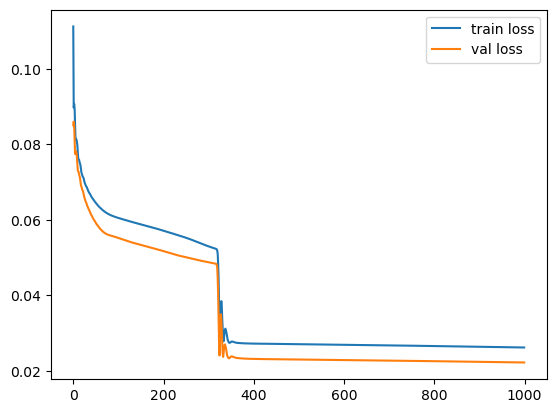

In [39]:
plot_history(history)

AssertionError: Expected tensors with same size, got torch.Size([1, 3, 1404, 2040]) and torch.Size([1, 3, 256, 256])

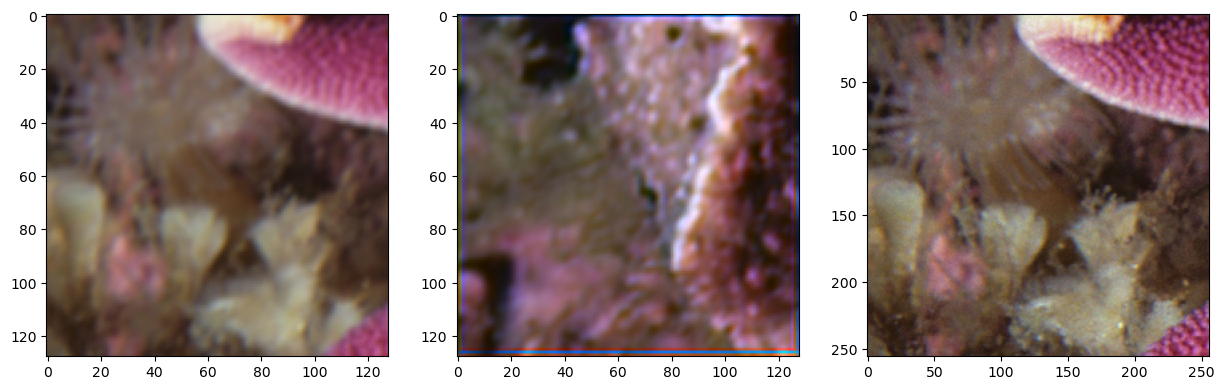

In [54]:
test = (images_lr_patches[0])[None,:]
#test = preds
model_deblur.eval()
with torch.no_grad():
    preds_hr = model_deblur(test)
img = preds_hr[0].permute(1,2,0).detach().cpu()
to_save = (preds_hr[0])/255
#torchvision.utils.save_image(to_save, 'out_div2k_hr.png')
#plt.imshow(img.type(torch.LongTensor))


plt.subplots(1,3, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(images_lr_patches[n].permute(1,2,0).type(torch.LongTensor))
plt.subplot(1,3,2)
plt.imshow(img.type(torch.LongTensor))
plt.subplot(1,3,3)
plt.imshow(images_hr_patches[n].permute(1,2,0).type(torch.LongTensor))

ssim_after = ssim(preds.to('cpu'), ref[None,:], data_range=255)
print(ssim_after)


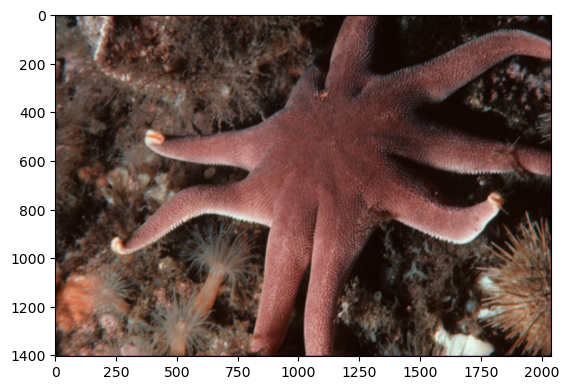

In [45]:
test = preds
model_deblur.eval()
with torch.no_grad():
    preds_hr = model_deblur(test)
img = preds_hr[0].permute(1,2,0).detach().cpu()
to_save = (preds_hr[0])/255
torchvision.utils.save_image(to_save, 'div2k_out.png')
plt.imshow(img.type(torch.LongTensor))

In [62]:
train_data

[tensor([[[0.3137, 0.3176, 0.3059,  ..., 0.1647, 0.1804, 0.2353],
          [0.3216, 0.3255, 0.3137,  ..., 0.1608, 0.1725, 0.2275],
          [0.3412, 0.3412, 0.3255,  ..., 0.1451, 0.1725, 0.2275],
          ...,
          [0.3255, 0.3255, 0.3255,  ..., 0.6627, 0.6196, 0.5961],
          [0.3294, 0.3294, 0.3333,  ..., 0.6706, 0.6235, 0.6157],
          [0.3255, 0.3255, 0.3373,  ..., 0.6745, 0.6392, 0.6314]],
 
         [[0.2549, 0.2588, 0.2431,  ..., 0.0941, 0.1294, 0.1922],
          [0.2588, 0.2627, 0.2471,  ..., 0.0941, 0.1255, 0.1804],
          [0.2745, 0.2667, 0.2549,  ..., 0.0824, 0.1255, 0.1922],
          ...,
          [0.2314, 0.2275, 0.2235,  ..., 0.4392, 0.4275, 0.4118],
          [0.2353, 0.2275, 0.2235,  ..., 0.4667, 0.4549, 0.4314],
          [0.2235, 0.2275, 0.2235,  ..., 0.4941, 0.4745, 0.4392]],
 
         [[0.2549, 0.2431, 0.2275,  ..., 0.1020, 0.1490, 0.1686],
          [0.2549, 0.2510, 0.2314,  ..., 0.0941, 0.1333, 0.1412],
          [0.2627, 0.2627, 0.2510,  ...,

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


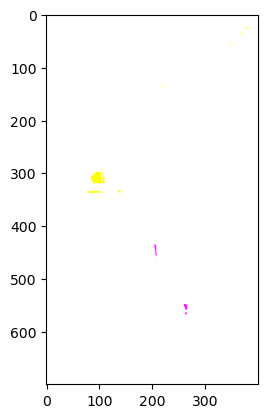

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,